<a href="https://colab.research.google.com/github/BorysZhyhalo/DataScience_RobotDreams/blob/main/Lesson16_AB_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B testing: A step-by-step guide in Python


Розглянемо процес аналізу A / B-теста від формування гіпотези, її перевірки і інтерпретації результатів. В якості даних будемо використовувати <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'>набір даних з Kaggle</a>, який містить результати A/B-теста двух різних дизайнів сторінки веб-сайта (old_page и new_page).
Наш план:

1. Дизайн експерименту
2. Збір і підготовка даних
3. Візуалізація результатів
4. Тестування гіпотези
5. Висновки


> Для більшої реалістичності уявимо ситуацію. Ви працюєте в онлайн-магазині. Дизайнер UX розробив нову версію сторінки продукта, сподіваючись, що це призведе до більшої конверсії покупок. Менеджер по продукту (PM) сказав вам, що поточний рівень конверсії в середньому 13% протягом року, і команда буде задоволена, якщо цей показник збільшиться на 2%. Це означає, що новий дизайн вважатиметься успішним, якщо коефіцієнт конверсії зросте до 15%.

> Для того, щоб прийняти рішення про запуск нового дизайну, спочатку вартує протестувати ефект на невеликій кількості користувачів і виконати A/B тестування.



## 1. Дизайн експерименту

### Формулювання гіпотези

Оскільки ми не знаємо краще чи гірше працюватиме новий дизайн, оберемо <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**двухсторонній  тест**</a>:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

$p$ и $p_0$ є коефіцієнтами конверсії нового і старого дизайну відповідно.

Встановимо **рівень значимості 5%**

$$\alpha = 0.05$$

Значення $\alpha$ - це встановлений нами поріг, за яким ми будемо визначати чи відхиляти нам нульову гіпотезу. Якщо пораховане нами $p$ -value нижче, ніж $\alpha$, то ми відхилимо нульову гіпотезу.

Отже, ми хочемо на 95% бути впевнені в тому, що відмінність коефіцієнтів конверсії для різних дизайнів є статистично значимою.

### Вибір змінних

* Група `control`  буде бачити старий дизайн
* `treatment`  группа буде бачити новий дизайн сторінки

Це значення ми будемо вважати незалежною змінною, адже весь інший функціонал, окрім дизайну сторінки, у користувачів обох груп однаковий.

Наша залежна змінна (тобто те, що ми намагаєтьсь виміряти) може бути закодована як:
* `0` - користувач не купив товар протягом цієї сесії
* `1` - користувач придбав товар протягом поточної сесії

Таким чином, ми зможемо легко порахувати середнє значення для кожної групи, щоб отримати коефіцієнт конверсії для кожного варіанту дизайна.

### Вибір розміру вибірки

Важливо відмітити, що ми будемо тестувати всю базу користувачів, яку маємо.

Кількість користувачів (їх сесій на сторінці) впливає на точність наших розрахункових показників конверсії. Але чим більшою стає наша вибірка, тим дорожчим стає наше дослідження.

На розмір вибірки впливає:

* **Statistical power** ($ 1 - \beta $) - вірогідність виявлення статистичної різниці між групами в нашому тесті, коли вона дійсно є. Зазвичай це значення встановлюють рівним 0.8
* **Significance level** ($ \alpha $) - 0.05.
* **Effect size** - наскільки великою має бути різниця між коефіцієнтами конверсії.

Оскільки для команди була достатньою різниця в 2%, ми можемо використати значення 13% и 15% для обрахунку очікуваного ефекту.

**Python надає функціонал для обрахунку цих значень**:

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
plt.show()

<ipython-input-7-04b897bb2c61>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
effect_size = sms.proportion_effectsize(0.13, 0.15)

In [ ]:
effect_size

-0.0576728617308947

In [ ]:
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )                                                  # розрахунок необхідного розміру вибірк

required_n = ceil(required_n)

print(required_n)

4720


Нам необхідно **мінімум 4720 спостережень для кожної групи**.

Параметр power на 0.8 на практиці означає, що якщо існує реальна різниця в коєфіцієнтах конверсії різних версій продукту, то в нас 80% шанс визначити її як статистино значиму в тесті з визначеним розміром вибірки.

***
## 2. Збір і підготовка даних

На практиці ви будете працювати з інженерами, щоб впевнитись, що ви зібрали необхідну кількість даних.

Але в даному прикладі:
1. Загрузимо набір даних з Kaggle.
2. Перевіримо і очистимо дані.
4. Випадковим чином оберемо n = 4720 рядків для кожної групи.


In [ ]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Давайте перевіримо, чи є користувачі, які зустрічаються кілька разів


In [ ]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'{multi_users} користувачі, які зустрічаються кілька разів.')

3894 користувачі, які зустрічаються кілька разів.


Оскільки їх небагато, давайте їх просто видалимо

In [ ]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'Новий розмір набору даних: {df.shape}')

Новий розмір набору даних: (286690, 5)


In [ ]:
# щоб впевнитись, що вся контрольна група бачить старий дизайн
df1 = df[(df['group'] == "control")]
df1.shape, df1[df1["landing_page"] == "new_page"].shape

((143293, 5), (0, 5))

In [ ]:
df1 = df[(df['group'] == "treatment")]
df1.shape, df1[df1["landing_page"] == "old_page"].shape

((143397, 5), (0, 5))

### Семплинг

Давайте оберемо необхідну кількість користувачів кожної групи

In [ ]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [ ]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [ ]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [ ]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

***
## 3. Візуалізація результатів

In [ ]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation
se_p = lambda x: stats.sem(x, ddof=0)            # (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Судячи з цифр, обидва дизайни працювали дуже схоже 12,3% проти 12,6% конверсії


<ipython-input-22-21982b4d6101>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)


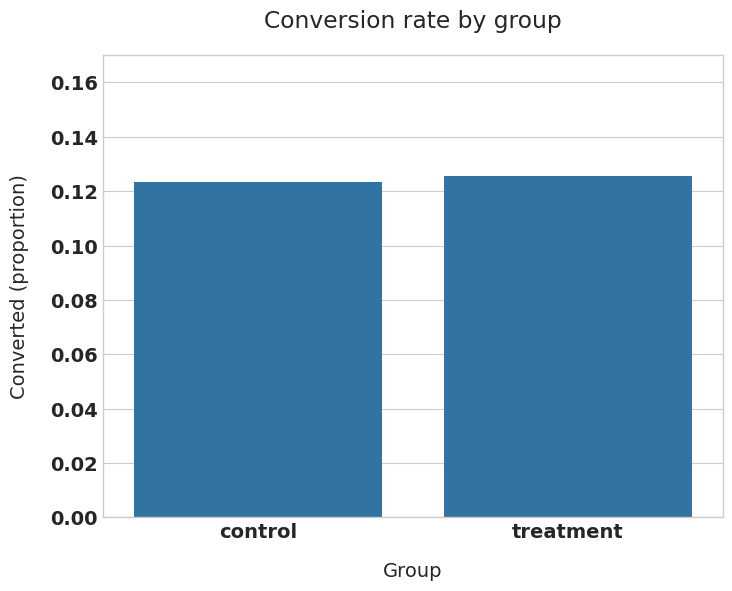

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

## 4. Тестування гіпотези

Оскільки в нас доволі велика вибірка, можемо використовувати <a href="https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval"> нормальне наближення </a> для для обчислення $p-value$ (z-тест).


In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [ ]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Довірчий інтервал 95% для групи control: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'Довірчий інтервал 95% для групи treatment: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
Довірчий інтервал 95% для групи control: [0.114, 0.133]
Довірчий інтервал 95% для групи treatment: [0.116, 0.135]


## 5. Висновки

Оскільки отримане $p$ -value=0.732 вище заданого $\alpha$ = 0.05, ми не можемо відхилити нульову гіпотезу $H_0$. Що означає, що новий дизайн не працював краще за попередній.
